# pyfit demo

## Autograd engine

In [1]:
from pyfit.engine import Scalar

### Reverse-mode autodiff

In [2]:
x = Scalar(1.0)
z = 2 * x + 2 + x
q = z + z * x
h = z * z
y = h + q + q * x
print(y.data) # 45.0
y.backward()
print(x.grad) # 62.0 (the numerical value of dy/dx)

45.0
62.0


### Computation graph

In [3]:
# pip install graphviz
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format='png')
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

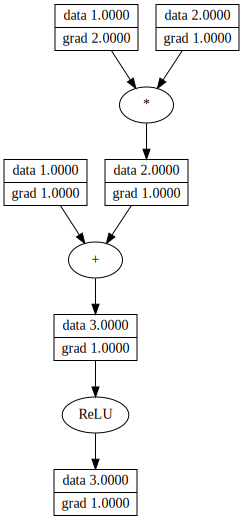

In [4]:
x = Scalar(1.0)
y = (x * 2 + 1).relu()
y.backward()
draw_dot(y)

## Neural network API

### Single neuron

In [5]:
import random
from pyfit.nn import Neuron

random.seed(1337)
n = Neuron(2)
print(n)
print(n.parameters())

ReLUNeuron(2)
[Scalar(data=0.23550571390294128, grad=0), Scalar(data=0.06653114721000164, grad=0), Scalar(data=0, grad=0)]


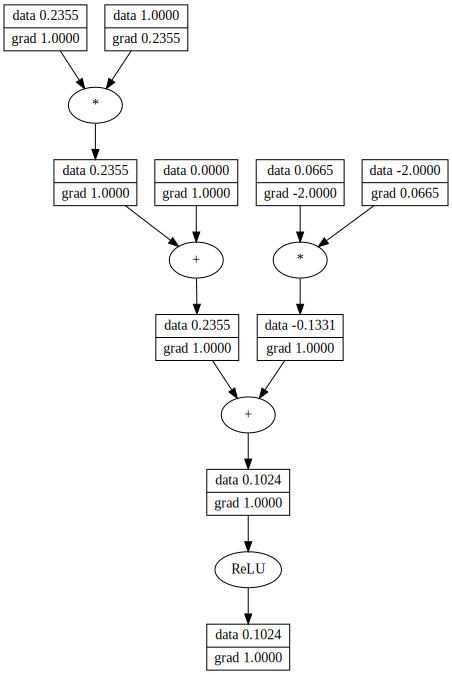

In [6]:
n.zero_grad()
x = [Scalar(1.0), Scalar(-2.0)]
y = n(x)
y.backward()
draw_dot(y)

### Learning XOR

In [7]:
from pyfit.engine import Scalar

inputs = [list(map(Scalar, x)) for x in [[0, 0], [0, 1], [1, 0], [1, 1]]]
print(inputs)
targets = [Scalar(0), Scalar(1), Scalar(1), Scalar(0)]

[[Scalar(data=0, grad=0), Scalar(data=0, grad=0)], [Scalar(data=0, grad=0), Scalar(data=1, grad=0)], [Scalar(data=1, grad=0), Scalar(data=0, grad=0)], [Scalar(data=1, grad=0), Scalar(data=1, grad=0)]]


In [8]:
from pyfit.nn import MLP

model = MLP(2, [4, 1]) # 1 hidden layer
print(model)
print(f"Number of parameters: {len(model.parameters())}")

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [LinearNeuron(4)]]
Number of parameters: 17


In [9]:
from pyfit.optim import SGD
from pyfit.loss import MSELoss
from pyfit.data import BatchIterator

optimizer = SGD(model.parameters(), learning_rate=0.1)
loss = MSELoss()
iterator = BatchIterator()

for epoch in range(500):
    # Reset the gradients of model parameters
    optimizer.zero_grad()
    epoch_loss = Scalar(0)
    for batch in iterator(inputs, targets):
        # Forward pass
        outputs = list(map(model, batch.inputs))
        # Loss computation
        y_pred = [item for sublist in outputs for item in sublist]
        batch_loss = loss(y_pred, batch.targets)
        epoch_loss += batch_loss
        # Backprop and gradient descent
        batch_loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}, loss = {batch_loss.data}")
    #print(model.parameters())

Epoch 0, loss = 0.34908237938599307
Epoch 1, loss = 0.253255579497783
Epoch 2, loss = 0.2139771602494559
Epoch 3, loss = 0.18620833416988497
Epoch 4, loss = 0.16691494841667798
Epoch 5, loss = 0.1456181174003039
Epoch 6, loss = 0.13132414891526217
Epoch 7, loss = 0.11957740564750108
Epoch 8, loss = 0.10692395650592795
Epoch 9, loss = 0.0992624824949938
Epoch 10, loss = 0.08968960033052101
Epoch 11, loss = 0.08300450199576315
Epoch 12, loss = 0.0764373481814047
Epoch 13, loss = 0.06953135913411435
Epoch 14, loss = 0.06566574134882362
Epoch 15, loss = 0.0596210729320006
Epoch 16, loss = 0.05539266436868229
Epoch 17, loss = 0.051918863374188995
Epoch 18, loss = 0.04849765342852369
Epoch 19, loss = 0.04489854640863375
Epoch 20, loss = 0.04248486585888561
Epoch 21, loss = 0.04038321259036619
Epoch 22, loss = 0.036634773014990366
Epoch 23, loss = 0.034601640026889174
Epoch 24, loss = 0.032272405721078375
Epoch 25, loss = 0.03067009476094068
Epoch 26, loss = 0.02821717460247468
Epoch 27, loss

Epoch 332, loss = 2.5301046608499865e-11
Epoch 333, loss = 2.3812141549043362e-11
Epoch 334, loss = 2.271449578137931e-11
Epoch 335, loss = 2.0659711807221698e-11
Epoch 336, loss = 1.9859071903652804e-11
Epoch 337, loss = 1.7335334736576935e-11
Epoch 338, loss = 1.8147983714531013e-11
Epoch 339, loss = 1.6189358644038963e-11
Epoch 340, loss = 1.4511989658838772e-11
Epoch 341, loss = 1.3926588500230414e-11
Epoch 342, loss = 1.2965615132953444e-11
Epoch 343, loss = 1.2875446995366971e-11
Epoch 344, loss = 1.1394954563361824e-11
Epoch 345, loss = 1.0226422195007667e-11
Epoch 346, loss = 1.0199775278480378e-11
Epoch 347, loss = 9.281787015111283e-12
Epoch 348, loss = 8.625795258548898e-12
Epoch 349, loss = 7.966511987128636e-12
Epoch 350, loss = 7.62933922358194e-12
Epoch 351, loss = 7.132010404220985e-12
Epoch 352, loss = 6.518877025440132e-12
Epoch 353, loss = 6.285244755281438e-12
Epoch 354, loss = 5.520654704554593e-12
Epoch 355, loss = 5.718464659305032e-12
Epoch 356, loss = 5.1336954